In [117]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

In [118]:
# Carregamento dos dados
df = pd.read_excel(r'/home/tcduarte/Reps/analise-awareness-python/case_analista_de_business_inteligence.xlsx',
                     sheet_name=1)

In [119]:
# Passa user_id para texto, para evitar cálculos conm a coluna
df['user_id'] = df['user_id'] .astype(str)

def cell_values_to_column(column_name):
    """
    Converte valores únicos em uma coluna em colunas binárias.

    Args:
        column_name (str): Nome da coluna a ser processada.

    Retorna:
        None: Modifica o DataFrame in-place.
    """

    def mass_replace_binary(value, if_true):
        """
        Substitui um valor por 1 se for igual ao valor de referência, caso contrário, 0.

        Args:
            value (any): Valor a ser comparado.
            if_true (any): Valor de referência.

        Retorna:
        int: 1 se os valores forem iguais, 0 caso contrário.
        """
        return 1 if value == if_true else 0
    
    # Para cada valor único, cria uma nova coluna binária
    for x in list(df[column_name].unique()):
        df[x] = df[column_name].apply(mass_replace_binary, if_true = x)

# Lista das colunas a terem uma coluna binária de cada um de seus valores
colunas_para_binarios = ['tipo', 'subtipo']

# Aplica a função para cada coluna na lista
for x in colunas_para_binarios:
    cell_values_to_column(x)

# Usar lambda e condicional para definir os perfis macro e micro
df['Perfil'] = df['seguidores'].apply(lambda x: 'Macro' if x >= 100000 else 'Micro')

# Separar uma amostra, baseada no desempenho dos influenciadores, para montar os clusters
visao_perfis = (df[['user_id',
                    'seguidores',
                    'impressoes',
                    'alcance',
                    'engajamentos',
                    'taxa_engajamento',
                    'alcance_efetivo'
                    ]]

                    .copy()
                    .groupby('user_id')
                    .mean()
                    .round(4))

# Renomeia as colunas para melhorar a legibilidade
df = df.rename(columns={'id_media': 'ID da midia',
                        'data_postagem': 'Data da postagem',
                        'user_id': 'ID do usuário',
                        'seguidores': 'Seguidores',
                        'tipo': 'Tipo',
                        'subtipo': 'Subtipo',
                        'impressoes': 'Impressões',
                        'alcance': 'Alcance',
                        'likes': 'Likes',
                        'comentarios': 'Comentários',
                        'saves': 'Saves',
                        'toques para tras': 'Toques para trás',
                        'respostas': 'Respostas',
                        'engajamentos': 'Engajamentos',
                        'taxa_engajamento': 'Taxa de engajamento',
                        'alcance_efetivo': 'Alcance Efetivo',
                        'stories': 'Stories',
                        'post': 'Posts',
                        'video': 'Video',
                        'image': 'Imagens',
                        'carousel': 'Carrosel'
                        })

# Salva o DataFrame em um arquivo CSV
df.to_csv(r'/home/tcduarte/Reps/analise-awareness-python/awareness.csv', index=False)

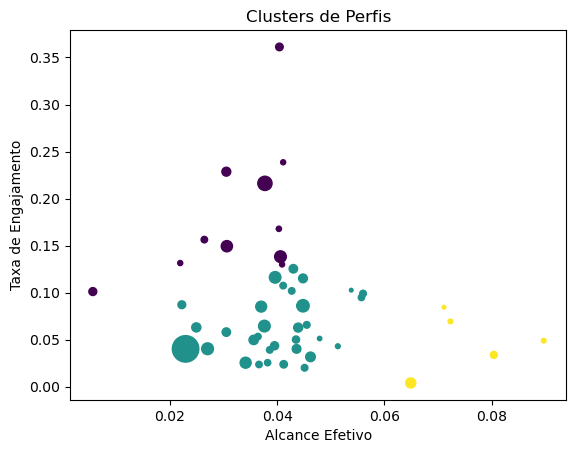

In [120]:
# Análise de Clusters

# A biblioteca warnings será utilizada nesse caso apenas para retirar os avisos das extensões, a qual
# nesse caso, pode atrapalhar a visualização das saidas do código.
with warnings.catch_warnings(record=True):

    # Padroniza os dados de impressões e engajamentos
    padronizador = StandardScaler()

    # Padronizando os dados para garantir que todas as features tenham a mesma escala
    dados_padronizados = padronizador.fit_transform(visao_perfis[['alcance_efetivo', 'taxa_engajamento']])

    # Criando o modelo K-means com 3 clusters
    kmeans = KMeans(n_clusters=3)

    # Ajustando o modelo aos dados padronizados
    kmeans.fit(dados_padronizados)

    # Adicionando os rótulos dos clusters ao DataFrame original
    visao_perfis['clusters'] = kmeans.labels_

    # Criando um gráfico de dispersão para visualizar os clusters e conferir os resultados
    plt.scatter(
        x=visao_perfis['taxa_engajamento'],
        y=visao_perfis['alcance_efetivo'],
        c=visao_perfis['clusters'],
        s=visao_perfis['seguidores'] / 2000
    )
    plt.xlabel('Alcance Efetivo')
    plt.ylabel('Taxa de Engajamento')
    plt.title('Clusters de Perfis')
    plt.show()

    # Adiciona os perfis também para a base de clusters
    # visao_perfis['Perfil'] = visao_perfis['seguidores'].apply(lambda x: 'Macro' if x >= 100000 else 'Micro')

    

    # Salvando os resultados em um arquivo CSV
    visao_perfis.to_csv(r'/home/tcduarte/Reps/analise-awareness-python/clusters.csv')